# 2.03c - Analysis of Night Clusters and BG Excursions
This notebook is used to analyse the night clusters and look for indications of BG control during the night by identifying BG excursions. The aim is to see if there are any patterns in the data that may indicate disturbances in sleep patterns, and to see if there are any differences between the night clusters.

Traditionally, glycaemic control has been assessed primarily through HbA1c measurements, which provide an average blood glucose level over the preceding two to three months. HbA1c remains a standard measure for predicting and preventing diabetes complications in a clinical setting, but has limitations. It does not capture daily fluctuations in glucose levels, including dangerous highs and lows. Therefore, patients can record a normal HbA1c but still experience significant glycaemic variability, which can lead to complications that will only present symptoms once they are having an impact on the body. CGM data provides a more detailed view of glucose levels, allowing for the assessment of glycaemic variability and excursions outside of target ranges. It can help to identify patterns in glucose levels that may not be captured by HbA1c alone, more effectively highlighting possible disturbances in sleep patterns.

Time in range (TIR) is a good indicator of BG control, but the definition of the ideal range is highly individual. For adults in the UK the general guidance is a target range is between 3.9–10 mmol/l. There are a number of factors that can influence this range however, such as disease duration, comorbities, pregnancy and others \cite{ElSayed2023}. For instance, for individuals in gestation are guided by a 3.5–7.8 mmol/l range, yet we do not have data on most of these influences to personalise the target accordingly. A search of academic papers on guidance for fasting target ranges refers mainly to diagnosis levels rather than guidance for those with T1D though some important institutes do indicate a  and therefore assume a consistent 3.9-10 mmol/l (70-180 mg/dL) concentration range as a general guideline, but this would normally be adjusted for individual needs.

If the level of blood glucose dips below the target range during sleep for a 15 minute period or longer, this is considered a nocturnal hypoclcaemic event. This is a significant event that can lead to complications such as seizures, coma, and even death. The same applies for hyperglycaemic events, where the blood glucose level rises above the target range for a 15 minute period or longer. These events are considered nocturnal hyperglycaemic events and can lead to complications such as diabetic ketoacidosis (DKA) and long-term complications such as cardiovascular disease. <REF> A characteristic of nocturnal hypoglycaemic events is that they are often asymptomatic unlike in healthy people, meaning that the patient may not be aware of the event \cite{Schultes2007}. The inference therefore is that these events may not be a cause of sleep disturbance of themselves. However, if intervention is required during an excursion (particularly where the closed loop system is unable to regulate the blood glucose levels), they are required to take quick-acting carbohydrates and persist in testing and iterating to ensure it comes back into range. This can lead to overnight disturbances.


In [81]:
from diptest import diptest
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import time
from IPython.display import display
from scipy.stats import linregress
import matplotlib.patches as mpatches

from src.nights import Nights, consolidate_df_from_nights
from src.sample_filter import SampleFilter
from src.configurations import ThirtyMinute
from src.night_clustering import NightClustering
from src.dba import dba_by_cluster
from src.config import PROCESSED_DATA_DIR
from src.helper import rank_minutes_series, normalise_overnight_time


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 0.2
iob_nan_min = 0.05
bg_nan_min = 0.2
sample_long = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min,
    bg_nan_min=bg_nan_min
)

df = sample_long.get_consolidated_df()
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))
df_variables = df[['bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max']].copy().astype(float)
analyser = NightClustering(df=df_variables, feature_settings='custom', night_start_hour=night_start.hour)
analyser.extract_night_level_features(multi_threaded=False)
analyser.preprocess_night_features(n_components=2)
cluster_range = range(2,8)
kwargs = {'perplexity': 10, 'max_iter': 80000}
analyser.fit_tsne(**kwargs)
analyser.clustering_tsne(n_clusters=4)

df_all = analyser.return_dataset_with_clusters()
df_all = df_all[['night_start_date', 'bg mean', 'bg min', 'bg max', 'iob mean', 'iob max', 'cob mean', 'cob max', 'tsne_cluster_label']].rename(columns={'tsne_cluster_label': 'cluster'})
print(f'Night count check: {len(df_all.reset_index()[["id","night_start_date"]].drop_duplicates())}')

2025-07-23 21:07:46.730 | INFO     | src.nights:_calculate_overall_stats:163 - No stats per night have been calculated for 67167655. Returning no output.
Number of nights objects created: 83


Feature Extraction:   0%|          | 23/6454 [00:00<00:28, 229.50it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  10%|▉         | 641/6454 [00:01<00:07, 738.17it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: RuntimeWarning: divide by zero encountered in log
  return -np.log(A / B)
Feature Extraction:  11%|█         | 726/6454 [00:01<00:07, 769.15it/s]C:\.env\master_project\Lib\site-packages\tsfresh\feature_extraction\feature_calculators.py:1753: Runtime

Extracted 78 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
Dropped features from scaling: {'iob max__count_above__t_100', 'cob max__minimum', 'cob mean__minimum'}
PCA reduced dimensions from 75 to 2.
Night count check: 922


In [83]:
df_all = df_all.join(df[['bg std', 'bg count', 'cob count', 'iob count']], how='left')  # Bring in columns for subsequent analysis, counts required for calc of background mean, std for background std and cv
df_all.to_csv(PROCESSED_DATA_DIR / 'night_clusters.csv', index=True)
df_all.to_parquet(PROCESSED_DATA_DIR / 'night_clusters.parquet', index=True)
bg_min = 70
bg_max = 180

def add_excursion_vars(df, var_name, bg_min, bg_max):
    min_name = 'min' if var_name == 'minmax' else 'mean'
    max_name = 'max' if var_name == 'minmax' else 'mean'
    df[f'bg_min_excursion_by_{min_name}'] = df[f'bg {min_name}'].apply(lambda x: (bg_min - x) if x < bg_min else np.nan)
    df[f'bg_max_excursion_by_{max_name}'] = df[f'bg {max_name}'].apply(lambda x: (x - bg_max) if x > bg_max else np.nan)

    def excursion_type(row):
        if pd.notna(row[f'bg_min_excursion_by_{min_name}']) and pd.notna(row[f'bg_max_excursion_by_{max_name}']):
            return 'IBR and IAR'
        elif pd.notna(row[f'bg_min_excursion_by_{min_name}']):
            return 'IBR'
        elif pd.notna(row[f'bg_max_excursion_by_{max_name}']):
            return 'IAR'
        else:
            return np.nan

    df['bg_excursion_type'] = (df[[f'bg_min_excursion_by_{min_name}', f'bg_max_excursion_by_{max_name}']].
                               apply(lambda x: excursion_type(x), axis=1))

    return df

df_all = add_excursion_vars(df_all, 'minmax', bg_min, bg_max)

BG excursion values are calculated as the difference between the BG min and max values and the target range of 70-180 mg/dL (3.9-10 mmol/l). In both cases, the value is calculated as an absolute value so that magnitude can be compared later on.

In [84]:
night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []
for zip_id, df_ind in df_all.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))

df_overnight = consolidate_df_from_nights(nights_objects)

We'll first look to see if there is any prevalence of BG excursions in the night clusters. Sleep is considered key to maintaining optimal cardiovascular and metabolic health. The relationship between sleep and glyaecemic control is complex and bi-directional. The effects of disrupted sleep on glucose control \cite{Farabi2016} and - conversely - impact of diabetes treatment on sleep \cite{Brod2013} have been studied but require more research. For instance, studies have associated the rapid decline in blood glucose over short periods with awakenings from sleep \cite{Pillar2003}, but little is known about causation.

By studying the amount of excursions outside a target glucose range, we can get an idea as to the frequency and extent of these excursions. Based on the assumptions given by other research, such excursions may infer - by association - some form of disturbance of sleep. Setting accurate thresholds is not possible when generalising over individuals.

The period we will consider studying once more is the 22:00-06:00 period as defining an arbitrary 'nocturnal' period. This is a period where we would expect the patient to be asleep and therefore not consuming food or taking insulin. Given our intervals are at 30 minutes we cannot accurately measure TOR, but we can look at intervals outside the target range, as well as the level of excursion above or below the target. At each interval we can focus on the BG min and max values at each interval which will have captured the peaks and troughs without smoothing these values, especially if short-lived. We know the OpenAPS system effectively manages BG in patients, so we would expect to see a lower number of excursions in the night clusters compared to the day clusters.

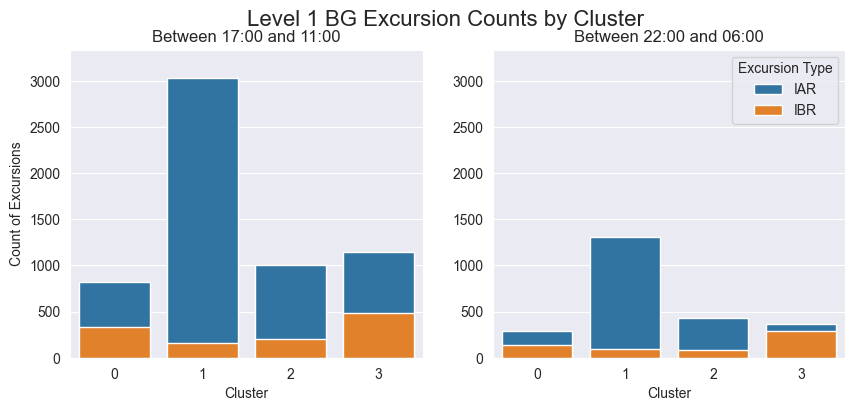

In [85]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.suptitle('Level 1 BG Excursion Counts by Cluster', fontsize=16)
df_all_excursion_summary = df_all.groupby(['cluster', 'bg_excursion_type']).size().reset_index(name='bg_excursions')

df_overnight_excursion_summary = df_overnight.groupby(['cluster', 'bg_excursion_type'])['bg_excursion_type'].size().reset_index(name='bg_excursions')
y_max = df_all_excursion_summary['bg_excursions'].max()
sns.barplot(df_all_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[0], legend=False)
axes[0].set_title('Between 17:00 and 11:00')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count of Excursions')
axes[0].set_ylim(0, y_max * 1.1)

sns.barplot(df_overnight_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[1])
axes[1].set_title('Between 22:00 and 06:00')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel(None)
axes[1].set_ylim(0, y_max * 1.1)

axes[1].legend(title='Excursion Type')
plt.show()


In [185]:
df_l1_excursions = df_all[['cluster', 'bg_min_excursion_by_min', 'bg_max_excursion_by_max']].reset_index().copy()
df_l1_excursions['time'] = df_l1_excursions['datetime'].dt.time
df_l1_excursions['time_rank'] = rank_minutes_series(df_l1_excursions['time'], time(17, 0))
df_violin = (df_l1_excursions.
             rename(columns={'bg_min_excursion_by_min': 'IBR', 'bg_max_excursion_by_max': 'IAR'}).
             melt(id_vars=['cluster', 'time', 'time_rank'],
                  value_vars=['IBR', 'IAR'],
                  var_name='excursion_type',
                  value_name='count').
             dropna(subset=['count']).
             sort_values(by=['cluster', 'excursion_type', 'time_rank'],))


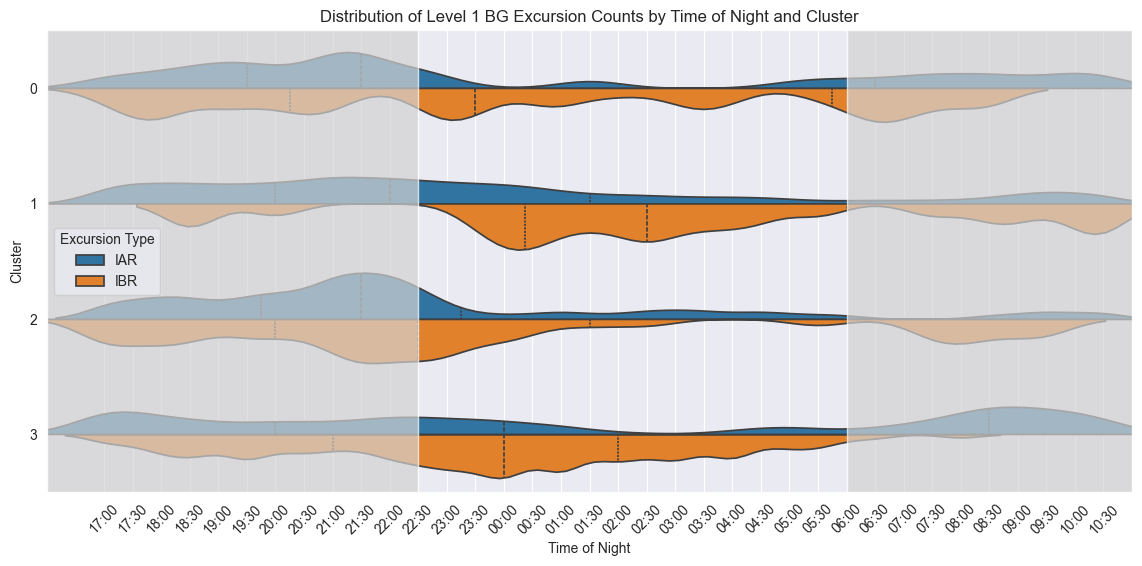

In [183]:
def get_xticks(df):
    df_new = df.copy()
    df_new['time'] = df_new['time'].apply(lambda x: x.strftime('%H:%M'))
    return df_new[['time_rank','time']].set_index('time_rank').drop_duplicates().sort_index()['time']

xticks = get_xticks(df_violin)

fig, ax = plt.subplots(figsize=(14, 6))
sns.violinplot(data=df_violin, x='time_rank', y='cluster', hue='excursion_type', split=True, inner='quartile', bw_method=0.1, orient='h')
shade_periods = [
    (-1, 12), # 17:00 to 22:00
    (27, 37)   # 06:00 to 11:00 (next day)
]
for start_dt_obj, end_dt_obj in shade_periods:
    ax.axvspan(start_dt_obj, end_dt_obj, facecolor='lightgray', alpha=0.7, zorder=3)
plt.title('Distribution of Level 1 BG Excursion Counts by Time of Night and Cluster')
plt.xlabel('Time of Night')
plt.ylabel('Cluster')
plt.xlim(-1, 37)
plt.legend(title='Excursion Type')
plt.xticks(ticks=sorted(df_violin['time_rank'].unique()), labels=xticks, rotation=45)
plt.show()

In [188]:
for t, group in df_violin.groupby('excursion_type'):
    print(f'Excursion Type: {t}')
    print(group.groupby('cluster')['count'].describe())
    print('\n')

Excursion Type: IAR
         count       mean        std  min   25%   50%   75%    max
cluster                                                           
0         49.0  20.336735  16.754784  3.0   6.0  14.0  30.0   69.0
1        993.0  43.582578  37.779419  1.0  14.0  33.0  60.0  151.0
2        103.0  22.233010  20.594690  1.0   8.0  17.0  32.0  116.0
3        135.0  23.248148  20.620222  1.0   6.5  19.0  30.5   94.0


Excursion Type: IBR
         count      mean       std  min  25%  50%   75%   max
cluster                                                      
0         39.0  6.025641  5.122125  1.0  2.0  4.0  10.0  15.0
1         24.0  7.666667  5.027461  1.0  3.0  7.0  13.0  15.0
2         41.0  6.609756  4.852206  1.0  3.0  6.0  10.0  15.0
3        124.0  7.620968  4.729415  1.0  4.0  6.0  12.0  15.0




This analysis of the density of the level 1 BG excursions shows the distributions of excursions for the nocturnal period in the context of the broader 17:00-11:00 period. It is noticable that for clusters 1 and 3, that there is visibly higher density within these periods

In [209]:
from datetime import datetime

norm_time = datetime(1900, 1, 1, 0, 0)
df_violin['norm_time'] = df_violin['time'].apply(lambda x: normalise_overnight_time(x, 11))
df_violin['minutes_delta'] = df_violin['norm_time'].apply(lambda x: ((x - norm_time).total_seconds() / 60)+15)
df_violin['count_times_minutes'] = df_violin['count'] * df_violin['minutes_delta']

In [210]:
mean_df_violin.groupby(['cluster', 'excursion_type']).agg(
    sum_countBy_mins=('count_times_minutes', 'sum'),
    total_excursion=('count', 'sum')
)

sum_countBy_mins  total_excursion
cluster excursion_type                                   
0       IAR                    1423567.5            996.5
        IBR                     358815.0            235.0
1       IAR                   60173782.5          43277.5
        IBR                     308220.0            184.0
2       IAR                    2996010.0           2290.0
        IBR                     378525.0            271.0
3       IAR                    4877002.5           3138.5
        IBR                    1360185.0            945.0

In [205]:
df_violin.sort_values(['cluster', 'excursion_type', 'time'], ascending=True)

,cluster,time,time_rank,excursion_type,count,minutes,date_start,norm_time,minutes_delta
47180,0,01:30:00,18,IAR,6.0,01:30:00,1900-01-02,1900-01-02 01:30:00,1545.0
63014,0,01:30:00,18,IAR,4.0,01:30:00,1900-01-02,1900-01-02 01:30:00,1545.0
62949,0,05:00:00,25,IAR,21.0,05:00:00,1900-01-02,1900-01-02 05:00:00,1755.0
62950,0,05:30:00,26,IAR,50.0,05:30:00,1900-01-02,1900-01-02 05:30:00,1785.0
62951,0,06:00:00,27,IAR,61.0,06:00:00,1900-01-02,1900-01-02 06:00:00,1815.0
...,...,...,...,...,...,...,...,...,...
7874,3,23:30:00,14,IBR,4.0,23:30:00,1900-01-01,1900-01-01 23:30:00,1425.0
9648,3,23:30:00,14,IBR,15.0,23:30:00,1900-01-01,1900-01-01 23:30:00,1425.0
10788,3,23:30:00,14,IBR,15.0,23:30:00,1900-01-01,1900-01-01 23:30:00,1425.0
28450,3,23:30:00,14,IBR,3.0,23:30:00,1900-01-01,1900-01-01 23:30:00,1425.0


In [86]:
df_overnight_excursion_summary.head()

,cluster,bg_excursion_type,bg_excursions
0,0,IAR,294
1,0,IBR,135
2,1,IAR,1305
3,1,IBR,99
4,2,IAR,428


In [87]:
def mean_excursions_by_night(df):
    excursions_per_night = (
        df.groupby(['id', 'night_start_date'])['bg_excursion_type']
        .apply(lambda x: x.notna().sum())
        .reset_index(name='excursion_count')
    )
    return excursions_per_night['excursion_count'].mean()

print(f'Mean excursions per night for 17:00-11:00 period (including zeros):{mean_excursions_by_night(df_all): .2f}')
print(f'Mean excursions per night for 22:00-06:00 period (including zeros):{mean_excursions_by_night(df_overnight): .2f}')

Mean excursions per night for 17:00-11:00 period (including zeros): 7.80
Mean excursions per night for 22:00-06:00 period (including zeros): 3.26


The plots show some interesting findings. Firstly, there are a significant number of excursions, more than had been expected. Secondly, there is a predominance of IAR excursions. Third, cluster 1 sees a significant number of IAR excursions (over 60% more), and cluster 3 sees more IBR excursions than other nights, though very few IAR excursions by comparison. However, these numbers are based on minimum and maximum values when resampled, giving no indication in the time out of range. Studies often use a time period of 15 minutes or upward to define an excursion, but this is not possible with the 30 minute intervals we have. By using the mean (aggregated from all readings in the 30 minute interval) we can get a better idea of the excursions, but this will not be entirely accurate as it may smooth out some of the excursions. Averaging these give us a slightly different picture, one would expect.

In [88]:
df_all_by_mean = add_excursion_vars(df_all, 'mean', bg_min, bg_max)
df_overnight_by_mean = add_excursion_vars(df_overnight, 'mean', bg_min, bg_max)
print('Mean excursions per night calculated using bg mean values:')
print(f'Mean excursions per night for 17:00-11:00 period (including zeros): {mean_excursions_by_night(df_all_by_mean): .2f}')
print(f'Mean excursions per night for 22:00-06:00 period (including zeros): {mean_excursions_by_night(df_overnight_by_mean): .2f}')

Mean excursions per night calculated using bg mean values:
Mean excursions per night for 17:00-11:00 period (including zeros):  6.55
Mean excursions per night for 22:00-06:00 period (including zeros):  2.78


In [89]:
# Per-night aggregation: stats and mutually exclusive flags
nightly = (
    df_overnight.groupby(['id', 'night_start_date', 'cluster'])
    .agg(
        max_excursion=('bg_max_excursion_by_max', 'max'),
        min_excursion=('bg_min_excursion_by_min', 'min'),
        IBR_night=('bg_excursion_type', lambda x: (x == 'IBR').any()),
        IAR_night=('bg_excursion_type', lambda x: (x == 'IAR').any()),
        excursion_count=('bg_excursion_type', lambda x: x.notna().sum()),
        IBR_count=('bg_excursion_type', lambda x: (x == 'IBR').sum()),
        IAR_count=('bg_excursion_type', lambda x: (x == 'IAR').sum())
    )
    .reset_index()
)
# Mutually exclusive flags
nightly['IBR_and_IAR_night'] = nightly['IBR_night'] & nightly['IAR_night']
nightly['IBR_only_night'] = nightly['IBR_night'] & ~nightly['IAR_night']
nightly['IAR_only_night'] = nightly['IAR_night'] & ~nightly['IBR_night']

# Per-patient aggregation
summary_by_id = (
    nightly.groupby('id')
    .agg(
        total_nights=('night_start_date', 'nunique'),
        nights_with_excursion=('excursion_count', lambda x: (x > 0).sum()),
        excursion_count=('excursion_count', 'sum'),
        IBR_count=('IBR_count', 'sum'),
        IAR_count=('IAR_count', 'sum'),
        max_excursion_mean=('max_excursion', 'mean'),
        min_excursion_mean=('min_excursion', 'mean'),
        nights_with_IBR=('IBR_only_night', 'sum'),
        nights_with_IAR=('IAR_only_night', 'sum'),
        nights_with_both_IBR_IAR=('IBR_and_IAR_night', 'sum')
    )
)
summary_by_cluster = (
    nightly.groupby('cluster')
    .agg(
        total_nights=('night_start_date', 'nunique'),
        nights_with_excursion=('excursion_count', lambda x: (x > 0).sum()),
        excursion_count=('excursion_count', 'sum'),
        IBR_count=('IBR_count', 'sum'),
        IAR_count=('IAR_count', 'sum'),
        max_excursion_mean=('max_excursion', 'mean'),
        min_excursion_mean=('min_excursion', 'mean'),
        nights_with_IBR=('IBR_only_night', 'sum'),
        nights_with_IAR=('IAR_only_night', 'sum'),
        nights_with_both_IBR_IAR=('IBR_and_IAR_night', 'sum')
    )
)

In [90]:
nightly

,id,night_start_date,cluster,max_excursion,min_excursion,IBR_night,IAR_night,excursion_count,IBR_count,IAR_count,IBR_and_IAR_night,IBR_only_night,IAR_only_night
0,15558575,2018-04-17,2,68.0,NaN,False,True,2,0,2,False,False,True
1,15558575,2018-04-21,2,NaN,NaN,False,False,0,0,0,False,False,False
2,15558575,2018-04-22,2,NaN,NaN,False,False,0,0,0,False,False,False
3,15558575,2018-04-27,2,42.0,NaN,False,True,5,0,5,False,False,True
4,15558575,2018-04-30,1,58.0,NaN,False,True,8,0,8,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,97417885,2018-02-09,1,84.0,4.0,False,True,8,0,8,False,False,True
918,97417885,2018-02-10,1,24.0,NaN,False,True,3,0,3,False,False,True
919,97417885,2018-02-11,1,50.0,NaN,False,True,2,0,2,False,False,True
920,97417885,2018-02-16,1,83.0,NaN,False,True,8,0,8,False,False,True


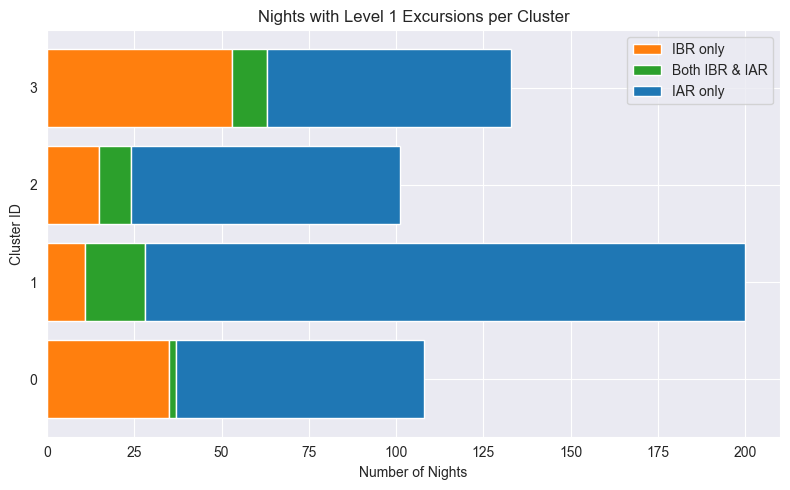

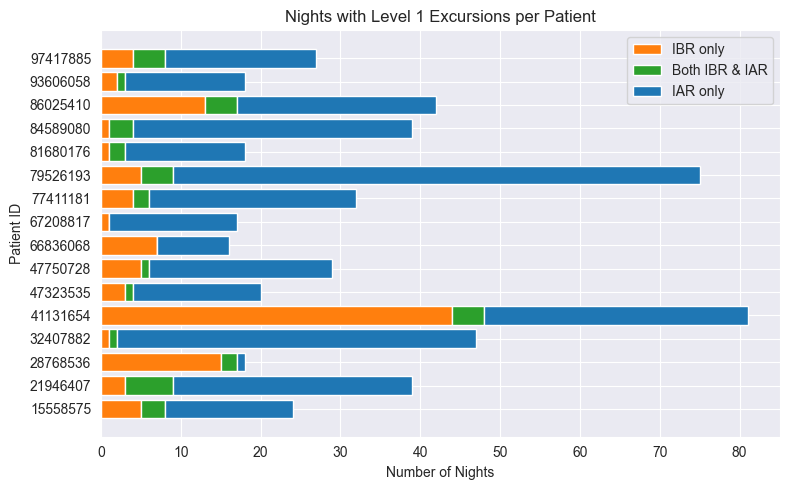

In [91]:
plot_df = summary_by_cluster[['nights_with_IBR', 'nights_with_IAR', 'nights_with_both_IBR_IAR']].copy()
plot_df.index = summary_by_cluster.index

def plot_nights_with_excursions(plot_df, title):
    fig, ax = plt.subplots(figsize=(8, 5))
    ids = plot_df.index.astype(str)
    bottom = None

    ax.barh(ids, plot_df['nights_with_IBR'], label='IBR only', color='#ff7f0e')
    ax.barh(ids, plot_df['nights_with_both_IBR_IAR'],
            left=plot_df['nights_with_IBR'],
            label='Both IBR & IAR', color='#2ca02c')
    ax.barh(ids, plot_df['nights_with_IAR'], left=plot_df['nights_with_IBR'] + plot_df['nights_with_both_IBR_IAR'], label='IAR only', color='#1f77b4')

    ax.set_xlabel('Number of Nights')
    ax.set_ylabel(f'{title} ID')
    ax.set_title(f'Nights with Level 1 Excursions per {title}')
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_nights_with_excursions(plot_df, 'Cluster')

plot_df = summary_by_id[['nights_with_IBR', 'nights_with_IAR', 'nights_with_both_IBR_IAR']].copy()
plot_df.index = summary_by_id.index  # Ensure patient IDs are the index
plot_nights_with_excursions(plot_df, 'Patient')

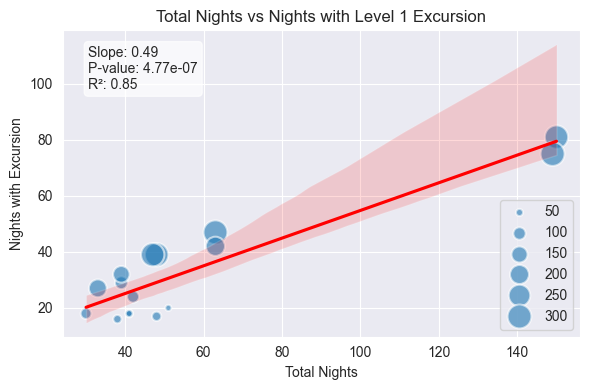

In [92]:
x = summary_by_id['total_nights']
y = summary_by_id['nights_with_excursion']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value ** 2

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    summary_by_id, x='total_nights', y='nights_with_excursion',
    size='excursion_count', sizes=(20, 300), edgecolor='white', linewidth=1.5, alpha=0.6, ax=ax,
)

sns.regplot(
    summary_by_id, x='total_nights', y='nights_with_excursion',
    scatter=False, ax=ax, color='red', line_kws={'label': 'Fit Line'}
)
ax.legend(title='Excursion Count')

ax.text(
    0.05, 0.95,
    f'Slope: {slope:.2f}\nP-value: {p_value:.3g}\nR²: {r_squared:.2f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)

plt.title('Total Nights vs Nights with Level 1 Excursion')
plt.xlabel('Total Nights')
plt.ylabel('Nights with Excursion')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [93]:
res = linregress(summary_by_id['total_nights'], summary_by_id['excursion_count'])
print('Linear Regression results for Total Nights vs Excursion Count:')
print(f'Slope: {res.slope:.2f}, P-value: {res.pvalue:.3g}, R²: {res.rvalue**2:.2f}')

Linear Regression results for Total Nights vs Excursion Count:
Slope: 1.67, P-value: 0.0148, R²: 0.36


The first and most notable observation is the high number of excursions that exist, following a linear relationship between the number of nights and the number of excursions. This is not unexpected, as the more nights we have, the more likely we are to have excursions. However, the a linear regression between the nights with excursions and total nights high correlation (with p-value < 0.05 and $R^2$ of 0.85 showing a good fit), indicating that the number of excursions does increase consistently with the number of nights. However, the number of nights is not necessarily correlated with the number of excursions which follows a Pearsons Correlation of $R=0.36$. This highlights that the instance of excursions follows an alternative relationship, likely with a predominance by individual, rather than the sample size.

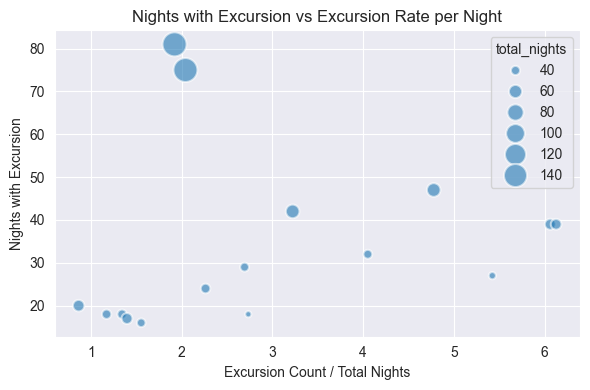

In [94]:
summary_by_id['excursion_ratio'] = summary_by_id['excursion_count'] / summary_by_id['total_nights']

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    summary_by_id, x='excursion_ratio', y='nights_with_excursion',
    size='total_nights', sizes=(20, 300), edgecolor='white', linewidth=1.5, alpha=0.6, ax=ax
)
plt.xlabel('Excursion Count / Total Nights')
plt.ylabel('Nights with Excursion')
plt.title('Nights with Excursion vs Excursion Rate per Night')
plt.grid(True)
plt.tight_layout()
plt.show()

Visualising the excursion ratio against the number of nights with excursions shows little information of discernible value with the number of patients we have in the sample. While there appears to be a correlation of sorts in the patients with the smaller number of nights with excursions, the picture is very different to those patient we have a night sample size of 120 or more.

In [95]:
def hist_data(df):
    new_df = df[['cluster', 'bg_min_excursion_by_min', 'bg_max_excursion_by_max']].reset_index().copy()
    new_df['time'] = new_df['datetime'].dt.time
    new_df['time_rank'] = rank_minutes_series(new_df['time'], night_start)
    new_df = (new_df.
             rename(columns={'bg_min_excursion_by_min': 'IBR', 'bg_max_excursion_by_max': 'IAR'}).
             melt(id_vars=['cluster', 'time', 'time_rank'],
                  value_vars=['IBR', 'IAR'],
                  var_name='excursion_type',
                  value_name='excursion_value').
             dropna(subset=['excursion_value']).
             sort_values(by='time_rank'))
    return new_df

df_hist_excursion = hist_data(df_overnight)
xticks = get_xticks(df_hist_excursion)

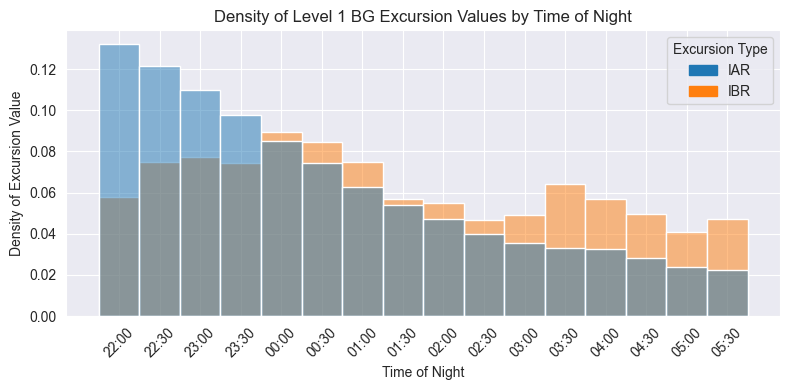

In [96]:
def all_density_plot(df_hist_excursion, xticks):
    fig = plt.figure(figsize=(8, 4))
    ax = plt.gca()
    palette = sns.color_palette(n_colors=df_hist_excursion['excursion_type'].nunique())
    excursion_types = df_hist_excursion['excursion_type'].unique()

    sns.histplot(
        df_hist_excursion, x='time_rank', hue='excursion_type', weights='excursion_value',
        stat='density', common_norm=False, binwidth=30, discrete=True, ax=ax, palette=palette
    )

    plt.xticks(ticks=df_hist_excursion['time_rank'].unique(), labels=xticks, rotation=45)
    plt.xlabel('Time of Night')
    plt.ylabel('Density of Excursion Value')
    plt.title('Density of Level 1 BG Excursion Values by Time of Night')

    # Custom legend handles
    handles = [
        mpatches.Patch(color=palette[i], label=excursion_types[i])
        for i in range(len(excursion_types))
    ]
    plt.legend(handles=handles, title='Excursion Type')

    plt.tight_layout()
    plt.show()

all_density_plot(df_hist_excursion, xticks)

In [97]:
df_overnight[['bg_max_excursion_by_max', 'bg_min_excursion_by_min']].describe()

,bg_max_excursion_by_max,bg_min_excursion_by_min
count,2397.000000,608.000000
mean,44.398415,10.143914
std,41.063787,8.276588
min,1.000000,0.500000
25%,14.000000,4.000000
50%,32.000000,7.000000
75%,64.000000,15.000000
max,221.000000,31.000000


In [98]:
from diptest import diptest
from scipy.stats import skew, kurtosis
ibr_values = df_overnight['bg_min_excursion_by_min'].dropna()
dip, p_value = diptest(ibr_values)
print(f'Dip Test for IBR: Dip Statistic = {dip:.4f}, p-value = {p_value:.4f}')

s = skew(ibr_values)
k = kurtosis(ibr_values)
print(f'Skewness for IBR: {s:.4f}, Kurtosis for IBR: {k:.4f}')
print(f'Bimodality Coefficient for IBR: {(s**2 + 1) / k}')


Dip Test for IBR: Dip Statistic = 0.0450, p-value = 0.0000
Skewness for IBR: 0.9973, Kurtosis for IBR: 0.0867
Bimodality Coefficient for IBR: 23.00548793511563


The density of the excursion value in histogram shows how the magnitude of blood glucose excursions (either IBR or IAR) is distributed across different time intervals during the night, for each cluster. Density means the plot is normalised so the area under the curve (or sum of bar heights) equals 1 for each group, allowing comparison of the shape of the distribution, regardless of the total number or sum of excursions. The excursion value is the amount by which blood glucose is outside the target range (either above or below). It provides a view of the times excursions are more or less likely, and how large they tend to be.

The IAR distribution is distinct and consistent over a count of 2397 excursion intervals, with a Q1 of 14 mg/dL and Q3 of 74 mg/dL, therefore 50% of excursions above L1 target range falls between 14 and 32 mg/dL. The maximum excursion however is 221 mg/dL. Interval with excursions below L1 target range number 608, with a Q1 of 4 mg/dL and a Q3 of 15 mg/dL. The max excursion is 31 mg/dL making these excursions less pronounced (and of course as a negative below the threshold). The IBR distribution also appears multimodal, evidenced with statistical significance from a dip test with p-value of < 0.05 that it is not unimodal, and a bimodality coefficient of 23 indicating a strong bimodial distribution. Looking at this by cluster may provide more insight into the distribution of excursions, and whether there are any differences between the clusters.

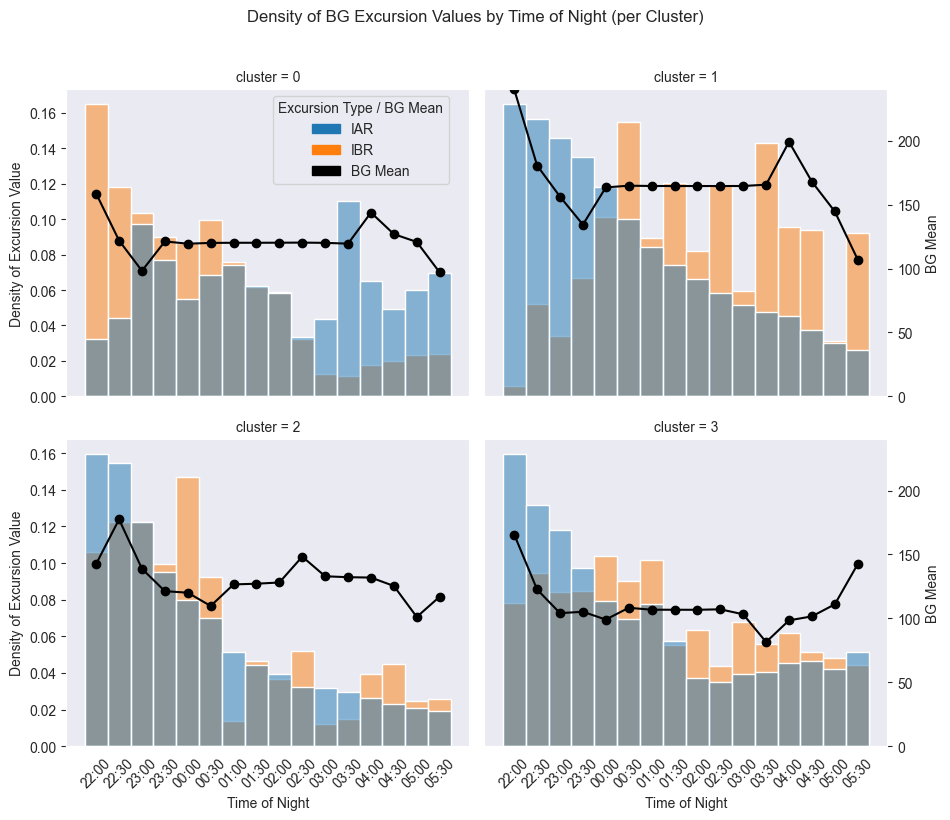

In [99]:
def excursion_density_by_cluster(df_hist_excursion, df_dba, xticks):
    max_dba = df_dba['bg mean'].max()

    g = sns.FacetGrid(
        df_hist_excursion,
        col='cluster',
        col_wrap=2,
        height=4,
        aspect=1.2,
        sharey=False
    )
    g.map_dataframe(
        sns.histplot,
        x='time_rank',
        hue='excursion_type',
        weights='excursion_value',
        stat='density',
        common_norm=False,
        binwidth=30,
        discrete=True,
        legend=False
    )
    axes = g.axes.flatten()
    ncols = 2

    for idx, (ax, cluster) in enumerate(zip(axes, g.col_names)):
        ax.set_xticks(df_hist_excursion['time_rank'].unique())
        ax.set_xticklabels(xticks, rotation=45)
        ax.set_xlabel('Time of Night')
        ax.set_ylabel('Density of Excursion Value')

        # Overlay line plot on secondary y-axis
        ax2 = ax.twinx()
        cluster_dba = df_dba[df_dba['cluster'] == cluster]
        ax2.plot(
            range(1, len(cluster_dba)+1),
            cluster_dba['bg mean'],
            color='black',
            marker='o',
            linestyle='-',
            label='BG Mean'
        )
        ax2.set_ylim(0, max_dba)
        ax2.set_ylabel('BG Mean')
        ax.grid(False)
        ax2.grid(False)

        # Remove secondary y-tick labels and label from left column
        if idx % ncols == 0:
            ax2.set_yticks([])
            ax2.set_ylabel(None)
        # Remove primary y-tick labels and label from right column
        if idx % ncols == 1:
            ax.set_yticks([])
            ax.set_ylabel(None)

    # Legend for histogram
    palette = g._legend_data if hasattr(g, '_legend_data') else None
    if palette:
        handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]
    else:
        excursion_types = df_hist_excursion['excursion_type'].unique()
        colors = sns.color_palette(n_colors=len(excursion_types))
        handles = [mpatches.Patch(color=colors[i], label=etype) for i, etype in enumerate(excursion_types)]

    # Add a single line legend
    line_handle = mpatches.Patch(color='black', label='BG Mean')
    g.fig.legend(handles=handles + [line_handle], title='Excursion Type / BG Mean', loc='upper right', bbox_to_anchor=(0.48, 0.92))

    g.fig.suptitle('Density of BG Excursion Values by Time of Night (per Cluster)', y=1.02)
    plt.tight_layout()
    plt.show()

variables = ['cob mean', 'iob mean', 'bg mean']

df_dba_by_cluster = dba_by_cluster(df_overnight, variables, night_start.hour, morning_end.hour, 'cluster')
excursion_density_by_cluster(df_hist_excursion, df_dba_by_cluster, xticks)


As we can see here, the distribution of excursion values for IAR over cluster 1, 2, 3 contribute to the overall distribution that starts with a peak and tails off towards the end of the night. This would naturally be expected as the patient is likely to be asleep and not consuming food or taking insulin. Cluster 0 however is more noisy, and it is IBR that has a more distinct distribution, akin to that of IBR in other clusters. IBR in general is more noisy, but the distribution is more pronounced in cluster 0. This may indicate that the patient is more likely to have IBR during the night, which may be indicative of a disturbance in their sleep pattern.

## Level 2 Hypoglycaemia and Hyperglycaemia Thresholds
There are two other thresholds that exist given their consideration as clinically significant. These are the level 2 hypoglycaemia threshold of 54 mg/dL (3.0 mmol/l) and the level 2 hyperglycaemia threshold of 250 mg/dL (13.9 mmol/l). These thresholds are used to indicate more severe excursions that may require intervention, such as a glucagon injection or insulin bolus. We can look at the number of excursions that occur outside these thresholds, and see if there is any difference between the night clusters.

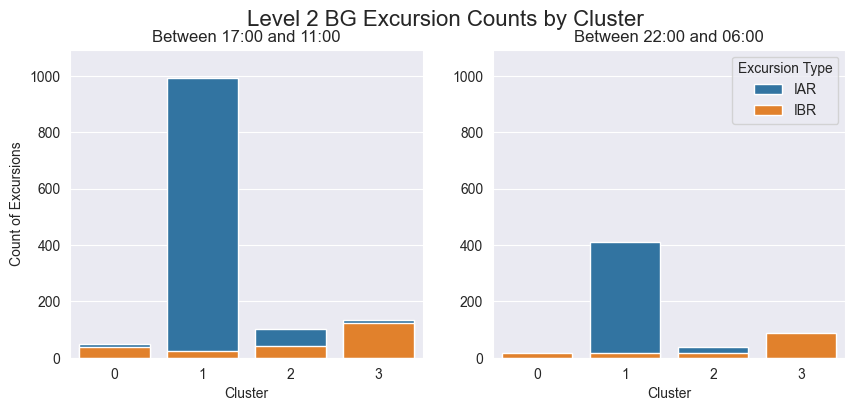

In [100]:
bg_min = 54
bg_max = 250
df_all_level2 = add_excursion_vars(df_all, 'minmax', bg_min, bg_max)
df_overnight_level2 = add_excursion_vars(df_overnight, 'minmax', bg_min, bg_max)
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
fig.suptitle('Level 2 BG Excursion Counts by Cluster', fontsize=16)
df_all_level2_excursion_summary = df_all_level2.groupby(['cluster', 'bg_excursion_type']).size().reset_index(name='bg_excursions')
df_overnight_level2_excursion_summary = df_overnight_level2.groupby(['cluster', 'bg_excursion_type'])['bg_excursion_type'].size().reset_index(name='bg_excursions')
y_max = df_all_level2_excursion_summary['bg_excursions'].max()
sns.barplot(df_all_level2_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[0], legend=False)
axes[0].set_title('Between 17:00 and 11:00')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count of Excursions')
axes[0].set_ylim(0, y_max * 1.1)
sns.barplot(df_overnight_level2_excursion_summary, x='cluster', y='bg_excursions', hue='bg_excursion_type', dodge=False, ax=axes[1])
axes[1].set_title('Between 22:00 and 06:00')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel(None)
axes[1].set_ylim(0, y_max * 1.1)
axes[1].legend(title='Excursion Type')
plt.show()


In [103]:
df_all[['cluster', ]]

night_start_date  bg mean  bg min  bg max  \
id       datetime                                                        
15558575 2018-04-17 17:00:00       2018-04-17  145.500   127.0   159.0   
         2018-04-17 17:30:00       2018-04-17   97.500    93.0   102.0   
         2018-04-17 18:00:00       2018-04-17   71.500    66.0    77.0   
         2018-04-17 18:30:00       2018-04-17   76.000    76.0    76.0   
         2018-04-17 19:00:00       2018-04-17  110.000   110.0   110.0   
...                                       ...      ...     ...     ...   
97417885 2018-02-18 08:30:00       2018-02-17  116.333   114.0   118.0   
         2018-02-18 09:00:00       2018-02-17  117.500   116.0   119.0   
         2018-02-18 09:30:00       2018-02-17  120.000   119.0   121.0   
         2018-02-18 10:00:00       2018-02-17  121.889   116.0   127.0   
         2018-02-18 10:30:00       2018-02-17  127.500   123.0   132.0   

                              iob mean  iob max  cob mean  cob max  cluster  \
id       datetime                                                             
15558575 2018-04-17 17:00:00     2.609    7.776     16.25     65.0        2   
         2018-04-17 17:30:00     6.045    6.425     58.50     59.0        2   
         2018-04-17 18:00:00     4.101    4.825     49.00     52.0        2   
         2018-04-17 18:30:00     1.623    1.623     51.00     51.0        2   
         2018-04-17 19:00:00     1.869    1.869     37.00     37.0        2   
...                                ...      ...       ...      ...      ...   
97417885 2018-02-18 08:30:00     0.193    0.272      0.00      0.0        1   
         2018-02-18 09:00:00     0.130    0.180      0.00      0.0        1   
         2018-02-18 09:30:00     0.152    0.160      0.00      0.0        1   
         2018-02-18 10:00:00     0.268    0.443      0.00      0.0        1   
         2018-02-18 10:30:00     0.313    0.410      0.00      0.0        1   

                              bg std  bg count  cob count  iob count  \
id       datetime                                                      
15558575 2018-04-17 17:00:00  14.248         4          4          4   
         2018-04-17 17:30:00   6.364         2          2          2   
         2018-04-17 18:00:00   7.778         2          2          2   
         2018-04-17 18:30:00    <NA>         1          1          1   
         2018-04-17 19:00:00    <NA>         1          1          1   
...                              ...       ...        ...        ...   
97417885 2018-02-18 08:30:00   2.082         3          3          3   
         2018-02-18 09:00:00   1.291         4          4          4   
         2018-02-18 09:30:00   1.414         2          2          2   
         2018-02-18 10:00:00   3.723         9          9          9   
         2018-02-18 10:30:00   3.391         6          6          6   

                              bg_min_excursion_by_min  \
id       datetime                                       
15558575 2018-04-17 17:00:00                      NaN   
         2018-04-17 17:30:00                      NaN   
         2018-04-17 18:00:00                      NaN   
         2018-04-17 18:30:00                      NaN   
         2018-04-17 19:00:00                      NaN   
...                                               ...   
97417885 2018-02-18 08:30:00                      NaN   
         2018-02-18 09:00:00                      NaN   
         2018-02-18 09:30:00                      NaN   
         2018-02-18 10:00:00                      NaN   
         2018-02-18 10:30:00                      NaN   

                              bg_max_excursion_by_max bg_excursion_type  \
id       datetime                                                         
15558575 2018-04-17 17:00:00                      NaN               NaN   
         2018-04-17 17:30:00                      NaN               NaN   
         2018-04-17 18:00:00                      NaN      

In [101]:
print(f'Mean excursions per night for 17:00-11:00 period (including zeros):{mean_excursions_by_night(df_all): .2f}')
print(f'Mean excursions per night for 22:00-06:00 period (including zeros):{mean_excursions_by_night(df_overnight): .2f}')

Mean excursions per night for 17:00-11:00 period (including zeros): 1.64
Mean excursions per night for 22:00-06:00 period (including zeros): 0.68


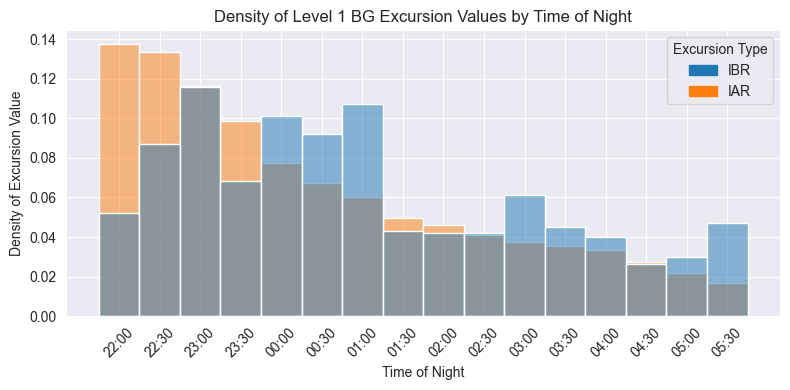

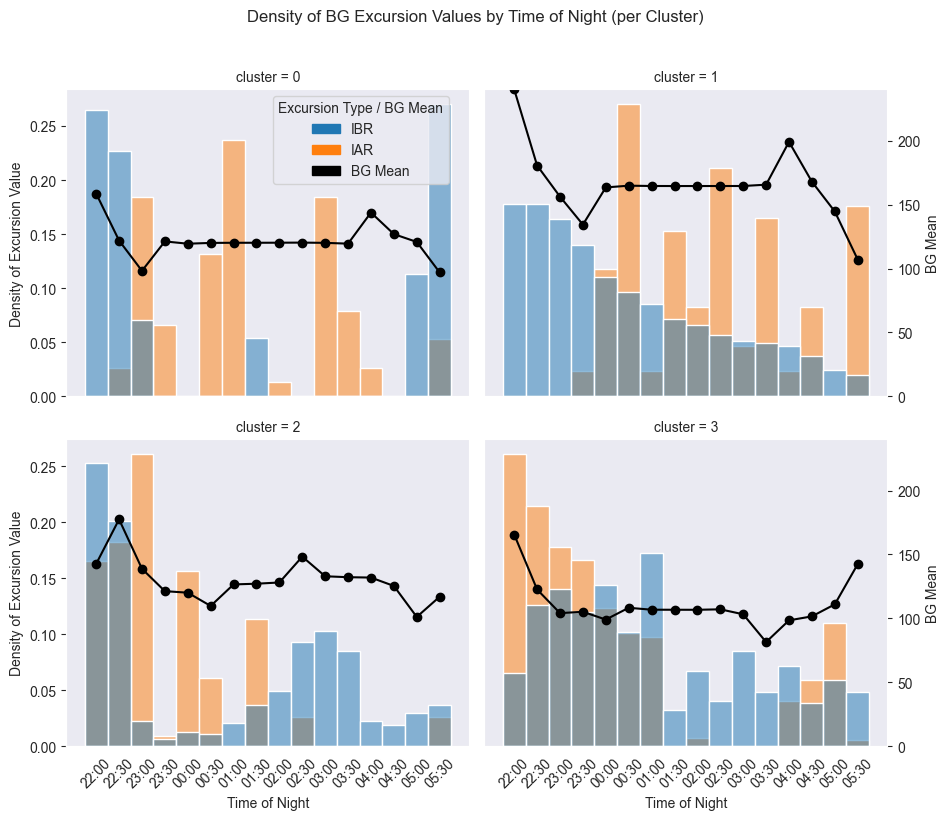

In [102]:
df_hist_excursion = hist_data(df_overnight_level2)
xticks = get_xticks(df_hist_excursion)
all_density_plot(df_hist_excursion, xticks)
df_dba_by_cluster = dba_by_cluster(df_overnight_level2, variables, night_start.hour, morning_end.hour, 'cluster')
excursion_density_by_cluster(df_hist_excursion, df_dba_by_cluster, xticks)

What we can see here is much less signal in the data. While the number of excursions is naturally much lower, much of the distribution is lost and the excursions tend to appear more random, apart from some cases such as IBR in cluster 3 which has a well-defined distribution.. This is a good indicator that the level 2 thresholds are more likely to present unique events and disturbances. In this picture, it is more difficult to see any patterns between the BG mean and excursions.